# Notebook that demonstrates the use of GMF models

In [1]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Build coordinate arrays

First we build 3D coordinate arrays in galactocentric coordinates $(\rho, \phi, z)$, where $\rho$ and $z$ are in units of kpc. 

In [3]:
x = np.linspace(-20.,20.,300)
y = np.linspace(-20.,20.,300)
z = np.linspace(-20.,20.,300)
xx,yy,zz = np.meshgrid(x, y, z, indexing = 'ij')

In [4]:
rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

In [5]:
print (rr.shape)

(300, 300, 300)


### Now initialize the GMF model. Models that are included are the Jansson & Farrar and the Pshirkov model.

### The Pshirkov model

For the Pshirkov model, both the bisymmetric (BSS) and the axisymmetric (ASS) versions are available.

In [6]:
pshirkov = gmf.GMF_Pshirkov(mode='ASS')

Get the disk component for the plane where $z = 0$

In [7]:
idz = np.argmin(np.abs(z))
print (idz)

149


In [8]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

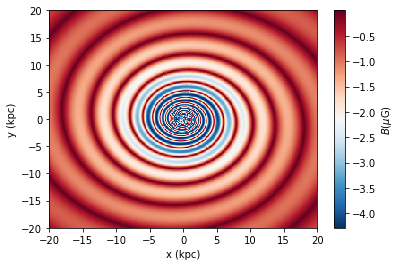

In [9]:
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap = plt.cm.RdBu_r)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

Get the halo component where $y = 0$

In [10]:
idy = np.argmin(np.abs(y))
print (idy)

149


In [11]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[:,i] = b[1]

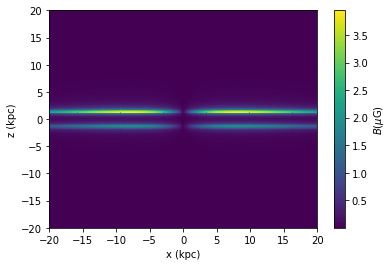

In [12]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo.T)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

The total model at some for $y = 0$:

### The Jansson & Farrar model

In [13]:
jansson = gmf.GMF()

In [14]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    b = jansson.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

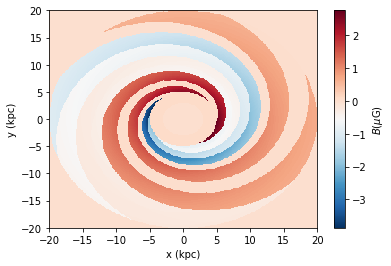

In [15]:
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap = plt.cm.RdBu_r)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

In [16]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[:,i] = b[1]

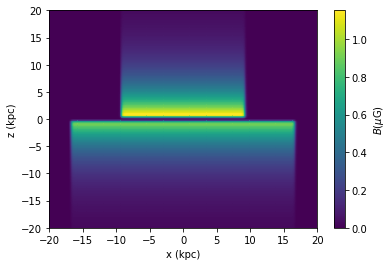

In [17]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo.T)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

In [18]:
BX = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.BX(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX[:,i] = b[1]

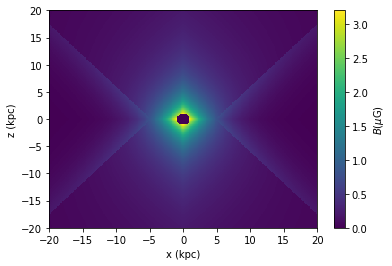

In [19]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX.T)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')